In [45]:
import pandas as pd
import numpy as np
import seaborn as sns
import os
import sys
import glob
import warnings
import cv2
import time

from matplotlib import pyplot as plt
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.cluster import MiniBatchKMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

sys.path.append("../")

load_dotenv()
# plt.style.use('Solarize_Light2')
# Setting default DPI, pulling it from dotenv if it exists, setting it on 100 if not

try:
    pc_dpi = int(os.getenv('DPI'))
except TypeError:
    pc_dpi = 100
if pc_dpi is None:
    pc_dpi = 100


# Classification using SIFT and Bag of Visual Words (BOWV, VBOW) :

- 0 : Image preprocessing using script @ ../image_preprocessing_mp.py
- 1 : Creating and assigning SIFT descriptors for each image
- 2 : Selecting vocabulary size and applying KMeans (or similar) to cluster descriptors with k cluster = vocabulary size, histogram creation
- 3 : Application of classification algorithm on histogram

<hr>

- 0 : Applied already : size harmonization (128, 128), contrast and histogram equalization, denoising using Gaussian filter, saved as grayscale in this use case (dir = gh_he)


In [2]:
image_dir = "../imgs/gs_he/"

image_paths = glob.glob(pathname=f"{image_dir}/*")


In [3]:
df = pd.read_pickle(filepath_or_buffer="../data/ecommerce_cleaned.pkl")

df.head()


,product_name,doc_desc,lem_desc,first_category,product_specifications,image,description,category_tree
0,Elegance Polyester Multicolor Abstract Eyelet ...,"(key, elegance, polyester, multicolor, abstrac...","[key, elegance, polyester, multicolor, abstrac...",home furnishing,"{""product_specification""=>[{""key""=>""Brand"", ""v...",55b85ea15a1536d46b7190ad6fff8ce7.jpg,Key Features of Elegance Polyester Multicolor ...,"[Home Furnishing, Curtains & Accessories, Curt..."
1,Sathiyas Cotton Bath Towel,"(sathiyas, cotton, bath, towel, bath, towel, r...","[sathiyas, cotton, bath, towel, bath, towel, r...",baby care,"{""product_specification""=>[{""key""=>""Machine Wa...",7b72c92c2f6c40268628ec5f14c6d590.jpg,Specifications of Sathiyas Cotton Bath Towel (...,"[Baby Care, Baby Bath & Skin, Baby Bath Towels..."
2,SANTOSH ROYAL FASHION Cotton Printed King size...,"(key, santosh, royal, fashion, cotton, print, ...","[key, santosh, royal, fashion, cotton, print, ...",home furnishing,"{""product_specification""=>[{""key""=>""Brand"", ""v...",d4684dcdc759dd9cdf41504698d737d8.jpg,Key Features of SANTOSH ROYAL FASHION Cotton P...,"[Home Furnishing, Bed Linen, Bedsheets, SANTOS..."
3,Jaipur Print Cotton Floral King sized Double B...,"(key, jaipur, print, cotton, floral, king, siz...","[key, jaipur, print, cotton, floral, king, siz...",home furnishing,"{""product_specification""=>[{""key""=>""Machine Wa...",6325b6870c54cd47be6ebfbffa620ec7.jpg,Key Features of Jaipur Print Cotton Floral Kin...,"[Home Furnishing, Bed Linen, Bedsheets, Jaipur..."
4,Maserati Time R8851116001 Analog Watch - For ...,"(maserati, time, analog, watch, boy, maserati,...","[maserati, time, analog, watch, boy, maserati,...",watches,"{""product_specification""=>[{""key""=>""Chronograp...",893aa5ed55f7cff2eccea7758d7a86bd.jpg,Maserati Time R8851116001 Analog Watch - For ...,"[Watches, Wrist Watches]"


In [4]:
# Let's discard anything that's not image or target related :

print(df.columns)


Index(['product_name', 'doc_desc', 'lem_desc', 'first_category',
       'product_specifications', 'image', 'description', 'category_tree'],
      dtype='object')


In [5]:
droplist = ["product_name", "doc_desc", "lem_desc", "product_specifications", "description", "category_tree"]

df.drop(columns=droplist, inplace=True, errors="ignore")

df.head()


,first_category,image
0,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
3,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg
4,watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg


In [6]:
df.rename(columns={"image": "image_name"}, inplace=True)

df.head()


,first_category,image_name
0,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg
1,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg
2,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg
3,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg
4,watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg


# 1 : Creation of SIFT features

- Creation of SIFT object, icreasing sensitivity to avoid image w/o descriptors
- Testing SIFT on image(s) to check sufficient keypoint detection
- Assigning the descriptors vectors for each image (might want to use multiprocessing if scaling up)

In [7]:
sift = cv2.SIFT_create(
    nOctaveLayers=8  # Augmenting sensitivity, increasing computationnal load
)


In [8]:
test_image = cv2.imread(image_paths[1], cv2.IMREAD_GRAYSCALE)


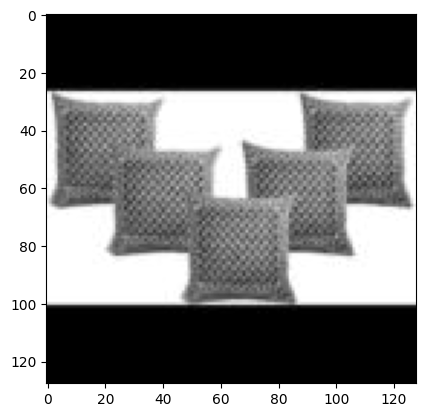

In [9]:
plt.imshow(test_image, cmap="gray")
plt.show()


In [10]:
keypoints, descriptors = sift.detectAndCompute(test_image, None)

image_keypoints = cv2.drawKeypoints(test_image, keypoints, test_image)


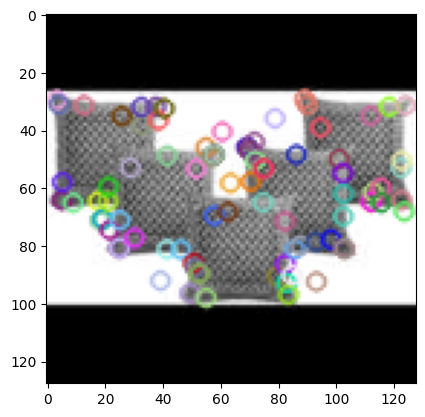

In [11]:
plt.imshow(image_keypoints)
plt.show()


In [12]:
def get_sift_descriptors(row):
    """
    Function : retrieves the image_name (its path), reads it using OpenCV and
    computing SIFT features, returning just the descriptors, discarding the keypoints

    Args : row of a dataframe for df.apply(fn)

    Returns : Array (numpy) of descriptors
    """

    image_name = row["image_name"]
    image_path = image_dir + image_name
    image = cv2.imread(
        filename=image_path,
        flags=cv2.IMREAD_GRAYSCALE
        )

    _, descriptors = sift.detectAndCompute(image, None)

    return descriptors


In [13]:
df["descriptors"] = df.apply(func=get_sift_descriptors, axis=1)


In [14]:
df.head()


,first_category,image_name,descriptors
0,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[[3.0, 24.0, 31.0, 58.0, 133.0, 5.0, 1.0, 1.0,..."
1,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[[6.0, 4.0, 0.0, 0.0, 12.0, 141.0, 5.0, 2.0, 8..."
2,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,"[[17.0, 22.0, 7.0, 3.0, 8.0, 39.0, 47.0, 54.0,..."
3,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 3.0, 119...."
4,watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg,"[[46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 166..."


In [15]:
# Checking NAs in Descriptors : 

print("descriptors : ", df["descriptors"].isna().sum())


descriptors :  0


In [16]:
df = df.dropna(subset=["descriptors"])


In [17]:
# Checking NAs in Descriptors : 

print("descriptors : ", df["descriptors"].isna().sum())


descriptors :  0


# 2 : Creating visual vocabulary :

- Concat. all descriptors into one matrix shape (number_descriptors, 128)
- Defining vocabulary size to 500 (around sqrt(descriptors_all)), adjusting to minmax computationnal costs and accuracy
- Clustering using KMeans with number of clusters = vocabulary
- Creation of BOVW (bag of visual words), histogram of size(vocab_size) counting the clusters retrieved via KMeans


In [18]:
descriptors_all = np.concatenate(df["descriptors"].values, axis=0)
descriptors_all.shape


(203416, 128)

In [19]:
# Using MiniBatchKMeans, reducing computationnal cost

vocab_size = 500

kmeans = MiniBatchKMeans(n_clusters=vocab_size, random_state=123, init="k-means++")


In [20]:
# MiniBatchKMeans : 

t_zero = time.perf_counter()

kmeans.fit(X=descriptors_all)

t_f = time.perf_counter()

print(f"Fitting time was {t_f - t_zero} s. with MiniBatchKmeans")


Fitting time was 5.370250334002776 s. with MiniBatchKmeans


In [21]:
def create_hist(row):

    descriptors = row["descriptors"]
    clusters_desc = kmeans.predict(X=descriptors)
    histogram = np.zeros(shape=vocab_size, dtype=int)

    for cluster in clusters_desc:
        histogram[cluster] += 1

    return histogram


In [22]:
df["bovw"] = df.apply(func=create_hist, axis=1)

df.head()


,first_category,image_name,descriptors,bovw
0,home furnishing,55b85ea15a1536d46b7190ad6fff8ce7.jpg,"[[3.0, 24.0, 31.0, 58.0, 133.0, 5.0, 1.0, 1.0,...","[0, 0, 1, 0, 0, 1, 0, 0, 3, 0, 0, 2, 0, 6, 0, ..."
1,baby care,7b72c92c2f6c40268628ec5f14c6d590.jpg,"[[6.0, 4.0, 0.0, 0.0, 12.0, 141.0, 5.0, 2.0, 8...","[0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 2, ..."
2,home furnishing,d4684dcdc759dd9cdf41504698d737d8.jpg,"[[17.0, 22.0, 7.0, 3.0, 8.0, 39.0, 47.0, 54.0,...","[0, 0, 0, 0, 2, 2, 1, 0, 0, 0, 1, 0, 1, 0, 1, ..."
3,home furnishing,6325b6870c54cd47be6ebfbffa620ec7.jpg,"[[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.0, 3.0, 119....","[0, 2, 0, 0, 2, 1, 0, 0, 1, 1, 3, 0, 4, 2, 1, ..."
4,watches,893aa5ed55f7cff2eccea7758d7a86bd.jpg,"[[46.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 166...","[0, 0, 2, 0, 0, 0, 2, 0, 1, 1, 0, 0, 0, 0, 0, ..."


<i>PCA might be useful here, especially if dimensions grow past 1000, in this case, a vector of 500 elements is still relevant for some algorithms like SVMs which are good in large dimensions contexts.</i>

# 3 : Using SVC to attempt a classification on the Bag Of Visual Words' histograms :

- GridSearchCV will be used to find best HPs in this case
- Labelencoder will be used on the targets (first category)

In [23]:
le = LabelEncoder()

df["encoded_category"] = le.fit_transform(df["first_category"])

df[["encoded_category", "first_category"]].head(n=5)


,encoded_category,first_category
0,3,home furnishing
1,0,baby care
2,3,home furnishing
3,3,home furnishing
4,6,watches


In [24]:
# Split :

X_train, X_test, y_train, y_test = train_test_split(
    np.stack(df["bovw"]),
    df["encoded_category"].values,
    test_size=0.3,
    random_state=123
)


In [36]:
# V Determined by trial and error

parameters = {
    "kernel": ["rbf", "linear"],
    "C": np.arange(2, 2.2, 0.025),
}

svc = SVC()

gridsearch_svc = GridSearchCV(
    estimator=svc,
    param_grid=parameters,
    scoring="accuracy",
    n_jobs=-1
)


In [37]:
t_zero = time.perf_counter()

gridsearch_svc.fit(X=X_train, y=y_train)

print(gridsearch_svc.best_params_)

print(f"execution : {time.perf_counter() - t_zero} s.")


{'C': 2.1249999999999996, 'kernel': 'rbf'}
execution : 3.377637458004756 s.


In [39]:
best_svc = gridsearch_svc.best_estimator_

# refitting just in case : 

best_svc.fit(X=X_train, y=y_train)


SVC(C=2.1249999999999996)

In [41]:
y_predict = best_svc.predict(X_test)

print(f"Accuracy score = {accuracy_score(y_true=y_test, y_pred=y_predict)}")


Accuracy score = 0.5


In [42]:
inv_y_predict = le.inverse_transform(y_predict)
inv_true = le.inverse_transform(y_test)

# This reverses the encoding on labels


In [43]:
print(classification_report(y_true=inv_true, y_pred=inv_y_predict))


                                 precision    recall  f1-score   support

                      baby care       0.37      0.50      0.42        34
beauty & personal care & health       0.64      0.62      0.63        55
     home decor & festive needs       0.31      0.33      0.32        45
                home furnishing       0.33      0.38      0.35        37
               kitchen & dining       0.56      0.58      0.57        50
                     multimedia       0.57      0.45      0.50        47
                        watches       0.83      0.60      0.70        40

                       accuracy                           0.50       308
                      macro avg       0.51      0.49      0.50       308
                   weighted avg       0.52      0.50      0.51       308



In [44]:
conf_matrix = pd.DataFrame(confusion_matrix(y_true=inv_true, y_pred=inv_y_predict))
conf_matrix.columns = le.inverse_transform(conf_matrix.columns)
conf_matrix.index = le.inverse_transform(conf_matrix.index)


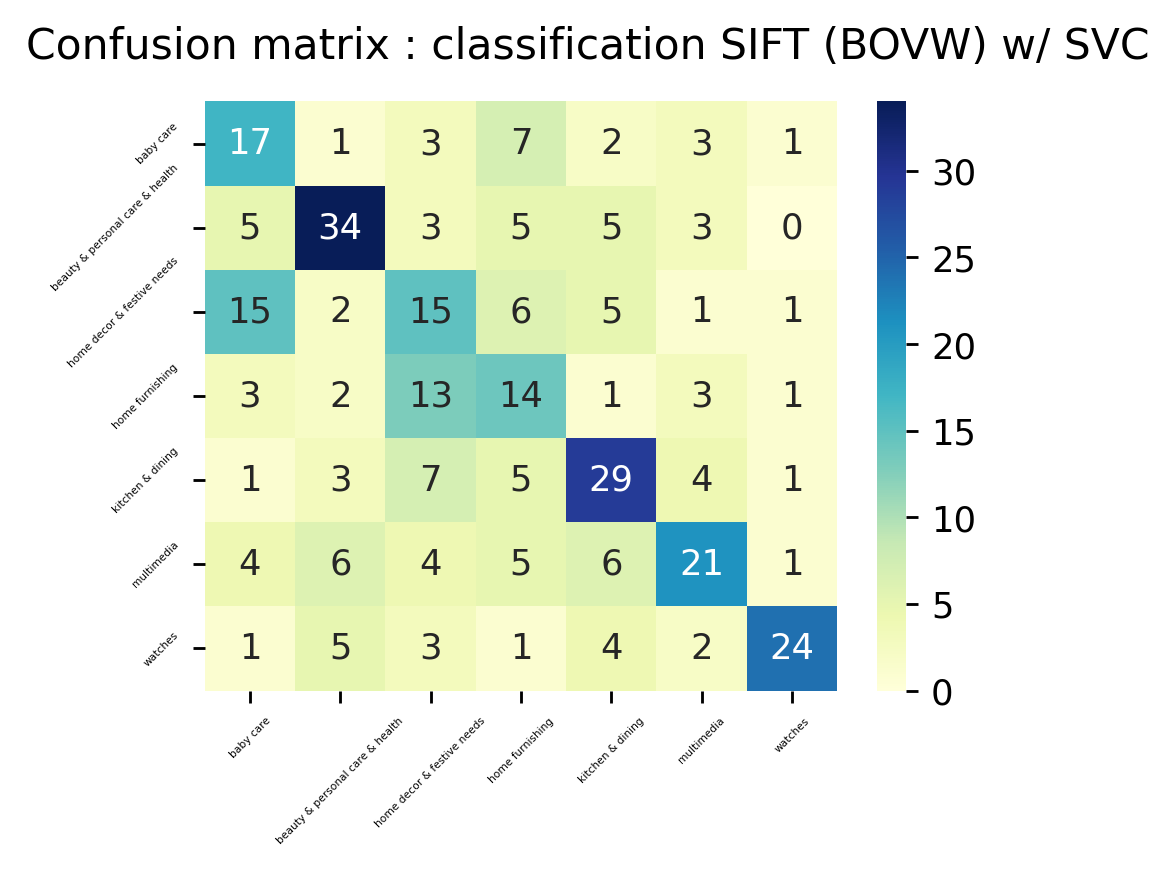

In [46]:
fig, (ax1) = plt.subplots(
    ncols=1,
    nrows=1,
    figsize=(4, 3),
    dpi=pc_dpi,
)

sns.heatmap(conf_matrix, annot=True, cmap="YlGnBu", xticklabels=True, yticklabels=True)

###
# Titles/Lables
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tick_params(labelsize=3)
fig.suptitle("Confusion matrix : classification SIFT (BOVW) w/ SVC")
#
###

plt.show()


# Observations and conclusions :

&emsp;While the performances on the classifications of the images alone are not as good as the classifications made on the description, certain categories are predicted quite well by SIFT + SVC : 
- We can see that Beauty and Personal Care, and to a certain degree, Watches, were often quite well identified. The explanation here might be as simple as saying that SIFT detected the packaging of beauty products well, or the shape of a watch, maybe the hands on the clock, etc.
- On the other hand, unsurprisingly, the algorithm confuses "Home Decor and Festive Needs" and "Home Furnishing" a lot. This was to be expected as we can imagine that the pictures were taken in a similar setting and the products could be similar on an image level.

&emsp;In these particular cases, a deeper analysis might be required to maybe adjust the labeling of the products and/or provide more precise images of the product by itself : many product images, especially in the Home Furnishing, Kitchen & Dining categories, are often photographed in a global setting with an environment. This might explain the confusion.
<br>

&emsp;It might be interesting to try using a CNN for this classification and see if we obtain better results with it.